In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people

from utils import multiplicative_updates, hals_update
from utils import plot_nmf_components, plot_reconstructed_images, plot_matrix_histogram, plot_reconstruction_error_vs_rank

# Nonnegative matrix factorization

## Linear dimensionality reduction (LDR)

---

La idea de LDR es representar cada punto de datos como una combinación lineal de un pequeño número de elementos base.

Matemáticamente, dado un conjunto de $n$ datos $x_1, \ldots, x_n \in\mathbb{R}^m$, LDR busca $r\ll\min\{m,n\}$ vectores base $w_1, \ldots, w_r \in\mathbb{R}^m$ tales que cada punto de datos $x_j$ esté bien aproximado por una combinación lineal de estos vectores base:
$$
    x_j\approx w_1\cdot h_{1j} +\cdots +w_r\cdot h_{rj}=
    \begin{bmatrix}
        w_1 \cdots w_r
    \end{bmatrix}
    \begin{bmatrix}
        h_{1j}\\
        \vdots\\
        h_{rj}
    \end{bmatrix}= W h_j,
$$
con $h_{ij}\in\mathbb{R}$.

### Forma matricial

Este modelo puede escribirse de forma compacta como 
$$
    \begin{bmatrix} x_1 \cdots x_n \end{bmatrix} \approx
    \begin{bmatrix} w_1 \cdots w_r \end{bmatrix}
    \begin{bmatrix} h_1 \cdots h_n \end{bmatrix},
$$
o como $X \approx WH$, donde:

- cada columna de $X\in\mathbb{R}^{m\times n}$ es un dato, $X(:,j)=x_j$;
- cada columna de $W\in\mathbb{R}^{m\times r}$ es un elemento base, $W(:,j)=w_j$;
- cada columna de $H\in\mathbb{R}^{r\times n}$ contiene las coordenadas del punto de datos $x_j$ en la base $W$, $H(:,j)=h_j$.

LDR produce una aproximación de rango $r$ $X\approx WH$, que es una *low-rank matrix approximation (LRMA)*

### La norma Frobenius

La medida de error que utilizaremos será la inducida por la norma Frobenius:

$$
    \|X-WH\|_F^2 = \sum_{i,j} (X-WH)_{ij}^2.
$$

### Nonnegative matrix factorization (NMF)

Dentro de los modelos de LDR, *nonnegative matrix factorization (NMF)* requiere que los factores $W$ y $H$ sean no negativas componente a componente. Esto lo denotamos como
$$
    W\geq 0,\quad H\geq 0.
$$

Formalmente, el problema de NMF es encontrar $W$ y $H$ que minimicen
$$
    \min_{\substack{W \in \mathbb{R}^{m \times r} \\ H \in \mathbb{R}^{r \times n}}} \|X-WH\|_F \quad \text{sujeto a } W \geq 0 \text{ and } H \geq 0.
$$

## Algoritmos NMF

A continuación, realizamos experimentos con dos algoritmos:

- *Multiplicative Updates (MU)*
- *Hierarchical Alternating Least Squares (HALS)*

En ambos casos, comenzamos generando matrices iniciales
$$
    W_0\geq 0,\quad H_0\geq 0.
$$
Posteriormente, estas matrices se actualizan de manera iterativa, siguiendo una regla de actualización específica para cada algoritmo.

### Inicialización

Algo que ayuda a la inicialización es considerar el valor
$$
    \alpha^* := \arg\min_{\alpha\geq 0} \|X-\alpha W_0H_0\|_F= \frac{\langle X, W_0H_0\rangle}{\langle W_0H_0, W_0H_0\rangle},
$$
y tomar como matrices iniciales del algoritmo a $W_{\text{init}}= \alpha^* W_0$ y $H_{\text{init}}= H_0$.

Así, la aproximación inicial es $\alpha^* W_0H_0$ en vez de $W_0H_0$, que tiene más error.

### Actualización MU

Las reglas de actualización de *multiplicative updates* son:
$$
    W \leftarrow W\circ \frac{\left[XH^T\right]}{\left[WHH^T\right]} \qquad \text{and}\qquad H \leftarrow H\circ \frac{\left[W^TX\right]}{\left[W^TWH\right]},
$$
donde $\circ$ y $\frac{[\ ]}{[\ ]}$ denotan respectivamente la multiplicación y división de matrices componente a componente.

### Actualización HALS

Por otro lado, *hierarchical alternating least squares* actualiza una columna de $W$ a la vez, dejando $H$ fija. Para $\ell= 1,\ldots, r$, se actualiza la columna $\ell$ de la siguiente manera:
$$
\begin{aligned}
    W(:,\ell) \leftarrow \arg\min_{w_\ell} &\left\|X -\sum_{k\neq\ell} W(:,k) H(k,:) -w_\ell H(\ell,:)\right\|_F \\
    &= \max\left(\quad 0 \quad ,\quad \frac{X H(\ell,:)^T -\sum_{k\neq \ell} W(:,k) \Big( H(k,:) H(\ell,:)^T\Big)}{\| H(\ell,:)\|_2^2}\quad \right)
\end{aligned}
$$

Luego se actualizan las columnas de $H$ de forma análoga, dejando $W$ fija.

### Experimento simple

In [19]:
n = 500 # n samples
m = 25 # m features
r = 20

np.random.seed(0)
X = np.abs(np.random.randn(n,m))

In [20]:
# Apply NMF
W, H = multiplicative_updates(
    X,
    n_components=r, 
    max_iter=500, 
    random_state=42, 
    verbose=True
)

# Check reconstruction
X_reconstructed =  W @ H
error = np.linalg.norm(X - X_reconstructed, 'fro')
print(f"MU: Final reconstruction error: {error:.4f}\n")

# Apply HALS
W, H = hals_update(
    X,
    n_components=r, 
    max_iter=500, 
    random_state=42, 
    verbose=True
)

# Check reconstruction
X_reconstructed =  W @ H
error = np.linalg.norm(X - X_reconstructed, 'fro')
print(f"HALS: Final reconstruction error: {error:.4f}")

Initial error: 69.0643
Converged at iteration 259 with relative change 9.7879e-05
MU: Final reconstruction error: 27.7930

Initial error: 69.0643
Converged at iteration 71 with relative change 9.7244e-05
HALS: Final reconstruction error: 27.7757


# NMF for Facial Feature Extraction

Dado un conjunto de imágenes en escala de grises con las mismas dimensiones, construyamos la matriz $X$ de modo que cada columna de $X$ corresponda a una imagen vectorizada en niveles de gris. Vectorizar significa transformar las imágenes bidimensionales en un vector unidimensional largo, por ejemplo, apilando las columnas de la imagen una sobre otra. Así, la entrada $X(i,j)$ es igual a la intensidad del $i$-ésimo píxel dentro de la $j$-ésima imagen, la cual es no negativa.

Abajo, aplicamos los algoritmos de NMF para una matriz $X$ formada a partir de un conjunto de datos de imágenes con caras.

## Labeled Faces in the Wild (LFW)

In [2]:
# Load LFW dataset
faces = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
images = faces.images  # shape (n_samples, height, width)

images_shape = images.shape[1:]
X = faces.data.T  # shape (n_features, n_samples)
    
print(f"Images shape: (height, width) = {images_shape}")
print(f"Dataset shape: (n,m) = {X.shape}")

Images shape: (height, width) = (50, 37)
Dataset shape: (n,m) = (1850, 1288)


## Iterate for different ranks

### MU

In [4]:
ranks = [5, 10, 20, 30, 40, 50, 60, 75, 100, 125, 150, 200]

os.makedirs("nmf_models", exist_ok=True)

for r in ranks:
    filename = f"nmf_models/mu_nmf_rank_{r}.npz"
    
    if os.path.exists(filename):
        print(f"File for rank {r} already exists. Skipping...")
        continue

    print(f"Training NMF for rank {r}...")
    W, H = multiplicative_updates(
        X,
        n_components=r, 
        max_iter=2000, 
        random_state=42,
        verbose=True
    )
    
    error = np.linalg.norm(X - W @ H, 'fro')

    np.savez_compressed(filename, W=W, H=H, error=error)

Training NMF for rank 5...
Initial error: 395.1906
Iteration 500/2000, Frobenius error: 160.0136
Iteration 1000/2000, Frobenius error: 159.8786
Iteration 1500/2000, Frobenius error: 159.8105
Iteration 2000/2000, Frobenius error: 159.7593
Training NMF for rank 10...
Initial error: 340.1345
Iteration 500/2000, Frobenius error: 142.6784
Iteration 1000/2000, Frobenius error: 142.1067
Iteration 1500/2000, Frobenius error: 141.9200
Iteration 2000/2000, Frobenius error: 141.8210
Training NMF for rank 20...
Initial error: 306.0037
Iteration 500/2000, Frobenius error: 123.6428
Iteration 1000/2000, Frobenius error: 122.3069
Iteration 1500/2000, Frobenius error: 121.9324
Iteration 2000/2000, Frobenius error: 121.7492
Training NMF for rank 30...
Initial error: 293.3768
Iteration 500/2000, Frobenius error: 113.8954
Iteration 1000/2000, Frobenius error: 112.0326
Iteration 1500/2000, Frobenius error: 111.3409
Iteration 2000/2000, Frobenius error: 110.9661
Training NMF for rank 40...
Initial error: 28

### HALS

In [4]:
ranks = [5, 10, 20, 30, 40, 50, 60, 75, 100, 125, 150, 200]

os.makedirs("nmf_models", exist_ok=True)

for r in ranks:
    filename = f"nmf_models/hals_nmf_rank_{r}.npz"
    
    if os.path.exists(filename):
        print(f"File for rank {r} already exists. Skipping...")
        continue

    print(f"Training HALS for rank {r}...")
    W, H = hals_update(
        X,
        n_components=r, 
        max_iter=2000, 
        random_state=42,
        verbose=True
    )
    
    error = np.linalg.norm(X - W @ H, 'fro')

    np.savez_compressed(filename, W=W, H=H, error=error)

Training HALS for rank 5...
Initial error: 395.1906
Converged at iteration 64 with relative change 9.9332e-05
Training HALS for rank 10...
Initial error: 340.1345
Converged at iteration 111 with relative change 9.9475e-05
Training HALS for rank 20...
Initial error: 306.0037
Converged at iteration 177 with relative change 9.9524e-05
Training HALS for rank 30...
Initial error: 293.3768
Converged at iteration 148 with relative change 9.9243e-05
Training HALS for rank 40...
Initial error: 288.8275
Converged at iteration 187 with relative change 9.8941e-05
Training HALS for rank 50...
Initial error: 285.6509
Converged at iteration 209 with relative change 9.9772e-05
Training HALS for rank 60...
Initial error: 282.6817
Converged at iteration 227 with relative change 9.9929e-05
Training HALS for rank 75...
Initial error: 278.9048
Converged at iteration 228 with relative change 9.9936e-05
Training HALS for rank 100...
Initial error: 276.4139
Converged at iteration 299 with relative change 9.97

## Reconstruction Error vs. Rank

### MU

Elbow at rank: 50


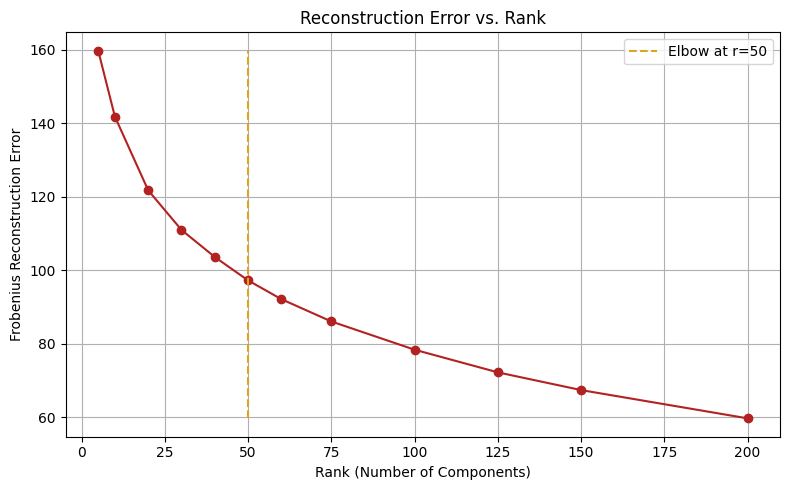

In [ ]:
ranks_vals = []
mu_error_vals = []

for r in ranks:
    filename = f"nmf_models/mu_nmf_rank_{r}.npz"
    if os.path.exists(filename):
        data = np.load(filename)
        ranks_vals.append(r)
        mu_error_vals.append(data['error'].item())

plot_reconstruction_error_vs_rank(ranks_vals, mu_error_vals)


The terms "knee" and "elbow" from the KneeLocator package both refer to the point of maximum curvature in a curve — often used to find the optimal value of a parameter like the number of components in PCA or NMF, or clusters in K-Means.

The KneeLocator package is a Python utility to automatically detect the "knee" or "elbow" point in a curve — which is usually where increasing a parameter (like rank) gives diminishing returns in reducing error.

They're the same concept, just used for curves with different orientations. Elbow: When the curve is decreasing (like reconstruction error vs. rank). Knee: When the curve is increasing (like explained variance vs. components).

### HALS

Elbow at rank: 60


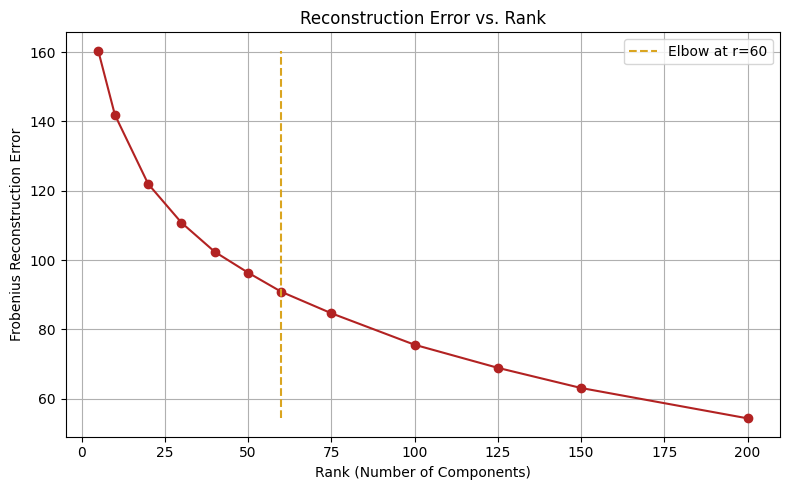

In [6]:
ranks_vals = []
hals_error_vals = []

for r in ranks:
    filename = f"nmf_models/hals_nmf_rank_{r}.npz"
    if os.path.exists(filename):
        data = np.load(filename)
        ranks_vals.append(r)
        hals_error_vals.append(data['error'].item())

plot_reconstruction_error_vs_rank(ranks_vals, hals_error_vals)


## Basis components and reconstruction

### MU

#### Rank-20


The reconstruction error for rank 20 is: 121.7492


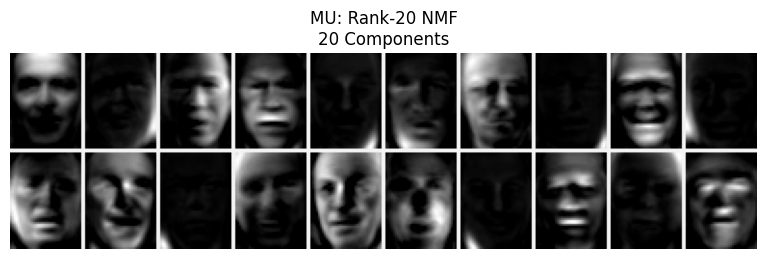

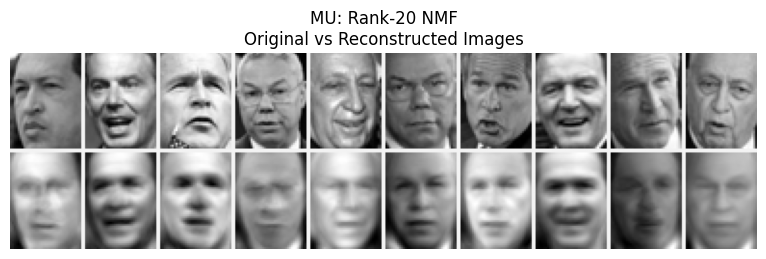

In [9]:
r = 20
data = np.load(f"nmf_models/mu_nmf_rank_{r}.npz")
W = data['W']
H = data['H']

# Check reconstruction
X_reconstructed = W @ H
error = np.linalg.norm(X - X_reconstructed, 'fro')
print(f"\nThe reconstruction error for rank {r} is: {error:.4f}")

n_components = 20
plot_nmf_components(
    W, 
    image_shape=images_shape, 
    n_components=n_components,
    n_cols=10, 
    title=f"MU: Rank-{r} NMF\n{n_components} Components"
)

plot_reconstructed_images(
    X, X_reconstructed,
    image_shape=images_shape,
    indices=list(range(0,10)),
    n_cols=10,
    title=f"MU: Rank-{r} NMF\nOriginal vs Reconstructed Images"
)

#### Rank-50


The reconstruction error for rank 50 is: 97.2173


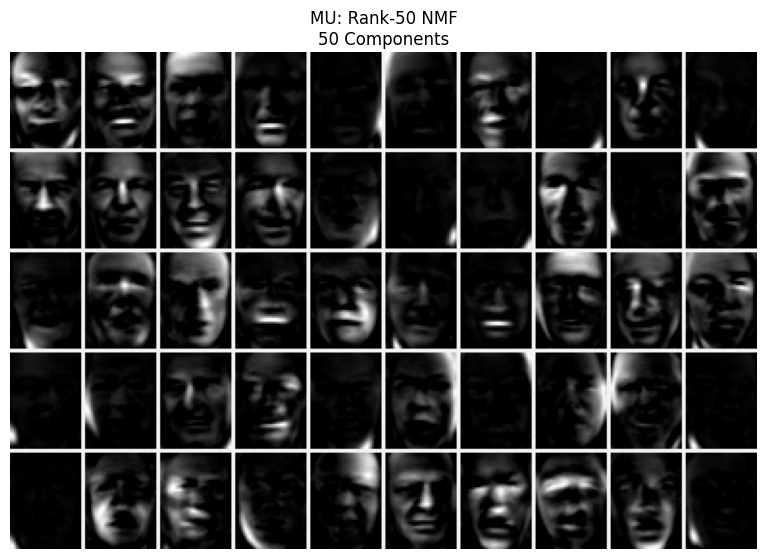

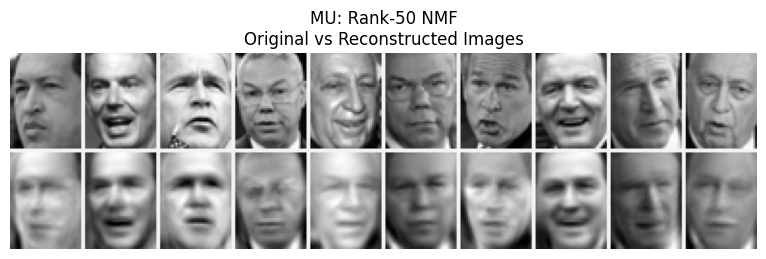

In [8]:
r = 50
data = np.load(f"nmf_models/mu_nmf_rank_{r}.npz")
W = data['W']
H = data['H']

# Check reconstruction
X_reconstructed = W @ H
error = np.linalg.norm(X - X_reconstructed, 'fro')
print(f"\nThe reconstruction error for rank {r} is: {error:.4f}")

n_components = 50
plot_nmf_components(
    W,
    image_shape=images_shape, 
    n_components=n_components,
    n_cols=10, 
    title=f"MU: Rank-{r} NMF\n{n_components} Components"
)

plot_reconstructed_images(
    X, X_reconstructed,
    image_shape=images_shape,
    indices=list(range(0,10)),
    n_cols=10,
    title=f"MU: Rank-{r} NMF\nOriginal vs Reconstructed Images"
)

#### Rank-200


The reconstruction error for rank 200 is: 59.6594


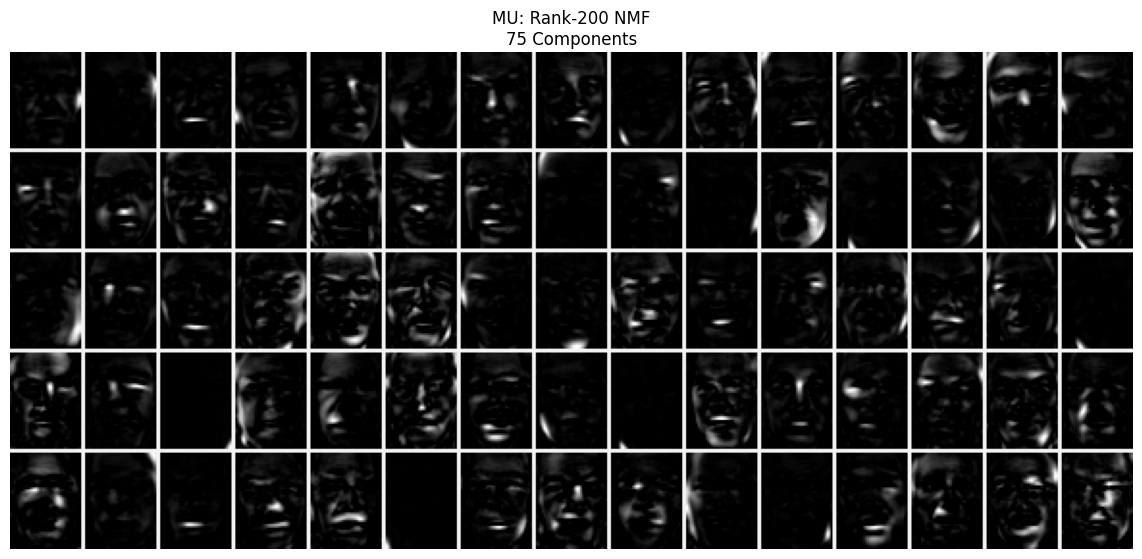

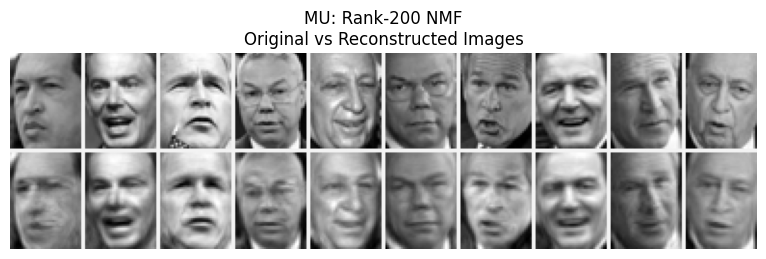

In [10]:
r = 200
data = np.load(f"nmf_models/mu_nmf_rank_{r}.npz")
W = data['W']
H = data['H']

# Check reconstruction
X_reconstructed = W @ H
error = np.linalg.norm(X - X_reconstructed, 'fro')
print(f"\nThe reconstruction error for rank {r} is: {error:.4f}")

n_components = 75
plot_nmf_components(
    W, 
    image_shape=images_shape, 
    n_components=n_components, 
    n_cols=15, 
    title=f"MU: Rank-{r} NMF\n{n_components} Components"
)

plot_reconstructed_images(
    X, X_reconstructed,
    image_shape=images_shape,
    indices=list(range(0,10)),
    n_cols=10,
    title=f"MU: Rank-{r} NMF\nOriginal vs Reconstructed Images"
)

## Sparcity

### MU

MU: Fraction of near-zero entries in rank-50 NMF:
    - In W: 34.32%
    - In H: 14.39%


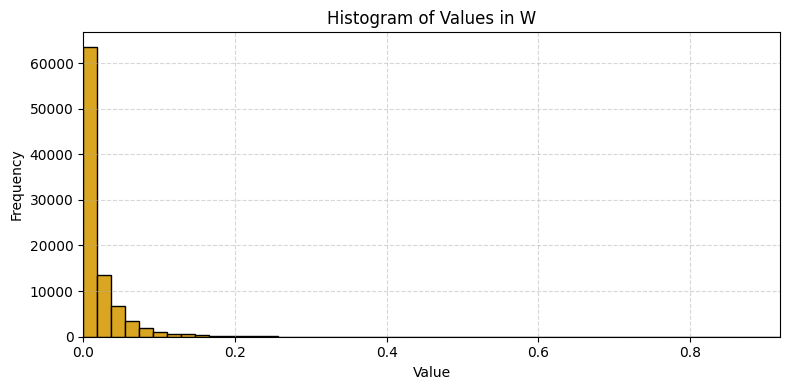

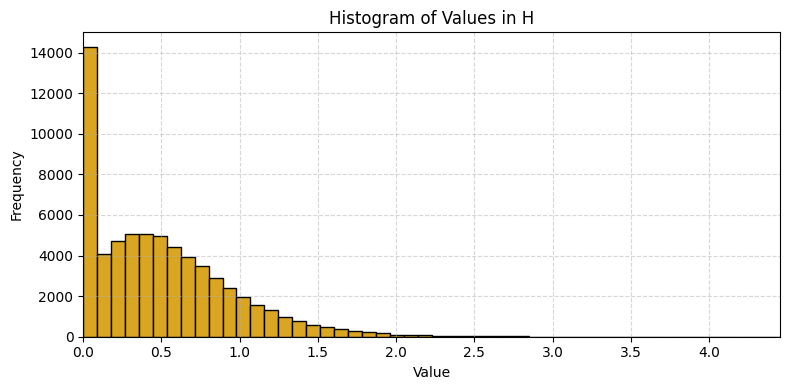

In [11]:
r = 50
data = np.load(f"nmf_models/mu_nmf_rank_{r}.npz")
W = data['W']
H = data['H']

print(f"MU: Fraction of near-zero entries in rank-{r} NMF:")
print(f"    - In W: {np.mean(W < 1e-3):.2%}")
print(f"    - In H: {np.mean(H < 1e-3):.2%}")

plot_matrix_histogram(W,"W")
plot_matrix_histogram(H,"H")

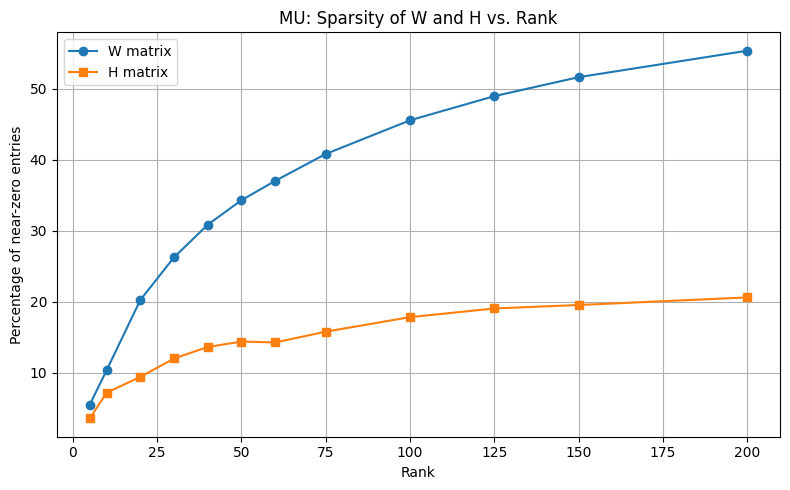

In [12]:
ranks_vals = []
mu_sparsity_vals_W = []
mu_sparsity_vals_H = []

for r in ranks:
    filename = f"nmf_models/mu_nmf_rank_{r}.npz"
    if os.path.exists(filename):
        data = np.load(filename)
        W = data['W']
        H = data['H']
        
        ranks_vals.append(r)
        # W < 1e-3 creates a boolean array
        mu_sparsity_vals_W.append(np.mean(W < 1e-3)*100)
        mu_sparsity_vals_H.append(np.mean(H < 1e-3)*100)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(ranks_vals, mu_sparsity_vals_W, marker='o', label='W matrix')
plt.plot(ranks_vals, mu_sparsity_vals_H, marker='s', label='H matrix')
plt.xlabel('Rank')
plt.ylabel('Percentage of near-zero entries')
plt.title('MU: Sparsity of W and H vs. Rank')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### HALS

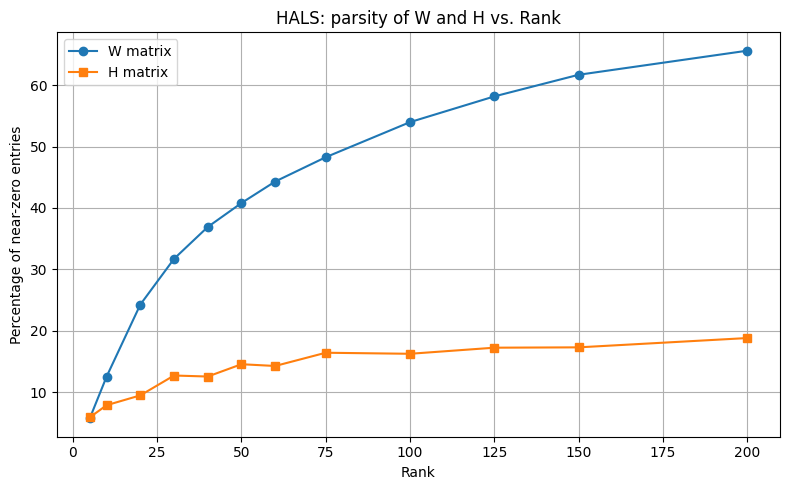

In [6]:
ranks_vals = []
hals_sparsity_vals_W = []
hals_sparsity_vals_H = []

for r in ranks:
    filename = f"nmf_models/hals_nmf_rank_{r}.npz"
    if os.path.exists(filename):
        data = np.load(filename)
        W = data['W']
        H = data['H']
        
        ranks_vals.append(r)
        # W < 1e-3 creates a boolean array
        hals_sparsity_vals_W.append(np.mean(W < 1e-3)*100)
        hals_sparsity_vals_H.append(np.mean(H < 1e-3)*100)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(ranks_vals, hals_sparsity_vals_W, marker='o', label='W matrix')
plt.plot(ranks_vals, hals_sparsity_vals_H, marker='s', label='H matrix')
plt.xlabel('Rank')
plt.ylabel('Percentage of near-zero entries')
plt.title('HALS: parsity of W and H vs. Rank')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Compare MU with HALS